# Linear SVM Classification

## Soft Margin Classification

ハードマージン: outlier(外れ値)を許容しない  
ソフトマージン: 許容する  

[LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html): リニアSVMの分類問題。

ハイパーパラメータCでマージン許容度をコントロール。小さければ(C=1)マージン大、大きければ(C=100)マージン小(違反が少ない)。Cを小さくしたほうがオーバーフィッティングを解消しやすい。

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris= datasets.load_iris()
X=iris["data"][:,(2,3)]
y=(iris["target"]==2).astype(np.float64)

svm_clf=Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge")),
])

svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [2]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

以下は等価。
`LinearSVC(C=1, loss="hinge")`=`SVC(kernel='linear', C=1)`=`SGDClassifier(loss='hinge', alpha=1/(m*c))`

`SGDClassifier()`は`LinearSVC()`よりすこし遅いがデータ数が多い場合などはこの書き方が有効。

# Nonlinear SVM Classification

より多くの特徴量を追加することで非線形データに対応。多項式にする。Pipelineでそれを実装。

In [3]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X,y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf=Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler',StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge', max_iter=10000)),
])

polynomial_svm_clf.fit(X,y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', max_iter=10000))])

make_moonsデータセットのプロット。

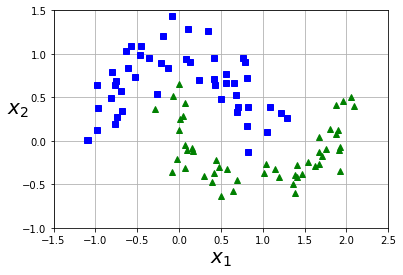

In [4]:
import matplotlib.pyplot as plt
def plot_dataset(X,y, axes):
    plt.plot(X[:,0][y==0], X[:,1][y==0], "bs")
    plt.plot(X[:,0][y==1], X[:,1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5,2.5, -1, 1.5])

予測結果のプロット。

In [5]:
def plot_predictions(clf, axes):
    x0s=np.linspace(axes[0], axes[1],100)
    x1s=np.linspace(axes[2], axes[3],100)
    x0, x1=np.meshgrid(x0s, x1s)
    X=np.c_[x0.ravel(), x1.ravel()]
    y_pred=clf.predict(X).reshape(x0.shape)
    y_decision=clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0,x1,y_pred,cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0,x1,y_decision,cmap=plt.cm.brg, alpha=0.1)
    

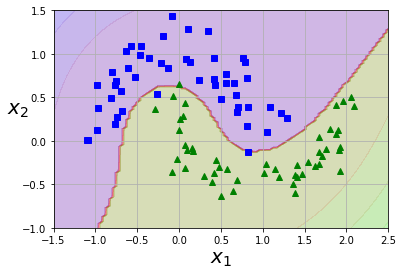

In [6]:
plot_predictions(polynomial_svm_clf,[-1.5,2.5,-1,1.5])
plot_dataset(X,y,[-1.5,2.5,-1,1.5])

## Polynomial Kernel

先の方法だと次数が大きくなるほど特徴量が増えモデルが遅くなる。

カーネルトリックを適用。[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)で`kernel=poly`と指定。



In [7]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

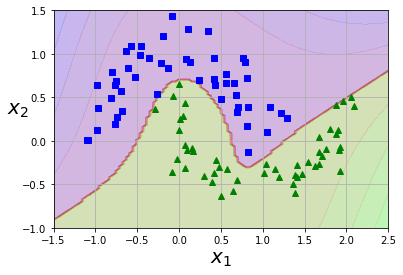

In [8]:
plot_predictions(poly_kernel_svm_clf,[-1.5,2.5,-1,1.5])
plot_dataset(X,y,[-1.5,2.5,-1,1.5])

## Gaussian RBF Kernel

多項式の代わりに類似度関数を用いる。ガウシアンRBF(Radial Basis Function)カーネル。

$$
\phi_\gamma(x, l)= \exp(-\gamma||x-l||^2)
$$

多項式の特徴量は特にデータセットが大きい場合に計算負荷が大きくなってしまう。`kernel="rbf"`とすることでガウシアンRBFカーネルを使用できる。

In [9]:
rbf_kernel_svm_clf=Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

γを大きくするとガウシアンの半値幅が狭くなる。オーバーフィッティングしたときは減らす。　

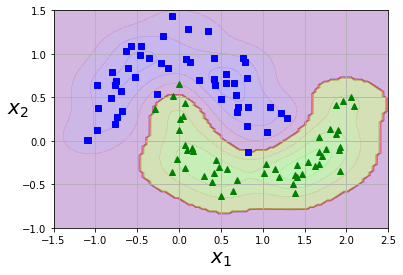

In [10]:
plot_predictions(rbf_kernel_svm_clf,[-1.5,2.5,-1,1.5])
plot_dataset(X,y,[-1.5,2.5,-1,1.5])

はじめはリニアカーネルから試すのがいい。特にデータ数が多い場合や特徴量が多い場合。データ数が多くなければガウシアンRBFを試す。時間と計算能力があればグリッドサーチで他のカーネルを試すといい。

# SVM Regression

[LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR): リニアSVMの回帰問題。

回帰問題ではマージンを最大化するのではなく最小化する。$\epsilon$でマージンの幅をコントロール、大きいほど広くなる。

In [11]:
from sklearn.svm import LinearSVR

svm_reg=LinearSVR(epsilon=1.5)
svm_reg.fit(X,y)

LinearSVR(epsilon=1.5)

非線形問題では[SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)でカーネルを指定する。

In [12]:
from sklearn.svm import SVR

svm_poly_reg=SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X,y)

SVR(C=100, degree=2, kernel='poly')